# **Vehicle Detection and Tracking**
---

![intro](https://i.imgur.com/AVVIes3.png)


**In this project, I have worked on the development of algorithm pipleline that detects vehicle objects in a visual scene and keeps tracking of them as long as the vehicle is apparently visual and detected in the scene.**

**Firstly, I have tested my algorithm on a group of test images.**

**Then, I have applied this pipeline to a test video stream.**

## Pipeline Architecture:
---

1. Extract vehicles and non-vehicles features
  * Prepare the dataset (get all images)
  * Split the data into training dataset and test dataset
  * Choose feature extraction paramters and extract the features
2. Traing a Support Vector Machine Classifier
  * Shuffle the data
  * Scale features
  * Fit the data to get the classification model
  * Testing our model accuracy using the test dataset
3. Find cars in a test image
  * Find cars in an image
    * Apply feature extraction for the test image using HoG sub-sampling using different sacles of the image
    * Scale features
    * Predict these features either to be car or non-car (false positives elimination using the `decision_function`)
    * Return the bounding box for the predicted cars in the image
  * Apply heat map for getting rid of multiple detection of the same object 

## Environment:
---
* Ubuntu 16.04 LTS
* Python 3.6.4
* OpenCV 3.1.0
* Anaconda 4.4.10

## Import Packages

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

## Support Function

Support functions (`or lesson functions`) that are used through the algorithm pipleline for color spaces conversion, features extraction, single image feature extraction, sliding window, find cars in an image, ... etc

**I will be giving a small description of each function explaining its purpose, inputs, and expected outputs**

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Descrition:
        This function converts an image from a color space to another. It converts:
        from RGB to YCrCb
        from BGR to YcrCb
        From RGB to LUV
    Paramteres:
        img: Image that we want to convert its color space
        conv: Conversion
    Output:
        Image converted to the required color space
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Descrition:
        This function extracts Histogram of Oriented Gradients (HoG) features from an image
    Paramteres:
        img: Image to extract HoG features from
        orient: Number of orientation bins
        pixels_per_cell: Size (in pixels) of a cell
        cells_per_block : Number of cells in each block.
        vis : a flag to return an image of the HOG or not
        feature_vec : returns the data as a feature vector by calling .ravel() on the result just before returning.
    Output:
        features: HoG features of the image
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    Descrition:
        This function computes binned color features of an image
    Paramteres:
        img: Image to compute its binned features
        size: Spatial binnign size
    Output:
        Spatially binned features vector of the image
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Descrition:
        This function computes color histogram features
    Paramteres:
        img: Image to compute its color histogram features
        nbins: Number of bins
        bins_range: bins range
    Output:
        hist_features: histogram features of the image
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Descrition:
        This function extracts the features from a list of images
    Paramteres:
        imgs: List of images
        color_space: The desired color space that we want to extract features in
        spatial_size: Spatial binning size
        hist_bins: Number of histogram bins
        orient: Number of orientation bins
        pixels_per_cell: Size (in pixels) of a cell
        cells_per_block : Number of cells in each block.
        hog_channel: The HoG channel in which we extract HoG featues
        spatial_feat : a flag to to add spatial features to the features vector or not
        hist_feat: a flag to to add histogram features to the features vector or not
        hog_feat: a flag to to add HoG features to the features vector or not
    Output:
        features: features of the image
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Descrition:
        This function applies a sliding window on the image
    Paramteres:
        img: Image to apply the sliding window to
        x_start_stop: Start and stop positions in x
        y_start_stop: Start and stop positions in 
        xy_window: Window size (x and y dimensions),
        xy_overlap: Overlap fraction (for both x and y)
    Output:
        window_list: Windows list
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Descrition:
        This function draws bouninding boxes on an image
    Paramteres:
        img: Image to draw bounding boxes on
        color: Color of the bounding box
        thick: Thickness of the bounding box
    Output:
        imcopy: Image with boudning boxes
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Descrition:
        This function extracts the features from a single images
    Paramteres:
        imgs: List of images
        color_space: The desired color space that we want to extract features in
        spatial_size: Spatial binning size
        hist_bins: Number of histogram bins
        orient: Number of orientation bins
        pixels_per_cell: Size (in pixels) of a cell
        cells_per_block : Number of cells in each block.
        hog_channel: The HoG channel in which we extract HoG featues
        spatial_feat : a flag to to add spatial features to the features vector or not
        hist_feat: a flag to to add histogram features to the features vector or not
        hog_feat: a flag to to add HoG features to the features vector or not
    Output:
        features: features of the image
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [121]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Descrition:
        This function takes a list of windows and decides each window is a car or not
    Paramteres:
        imgs: Image to search on cars
        windows: List of windows (output of slide_windows())
        clf: The classification model
        scaler: Features scaling object
        color_space: The desired color space that we want to extract features in
        spatial_size: Spatial binning size
        hist_bins: Number of histogram bins
        hist_range: The range of histogram
        orient: Number of orientation bins
        pixels_per_cell: Size (in pixels) of a cell
        cells_per_block : Number of cells in each block.
        hog_channel: The HoG channel in which we extract HoG featues
        spatial_feat : a flag to to add spatial features to the features vector or not
        hist_feat: a flag to to add histogram features to the features vector or not
        hog_feat: a flag to to add HoG features to the features vector or not
    Output:
        on_windows: Windows of positive detections
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        #prediction = clf.predict(test_features)
        prediction = clf.decision_function(test_features)
#        print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction >= 1.8:
            #print(prediction)
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [240]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Descrition:
        This function extracts features using hog sub-sampling and makes predictions
    Paramteres:
        imgs: Image to search on cars
        ystart: The start of y position search area
        ystop: The stop of y pisition search area
        scale: Image scaling factor
        svc: The classification model
        X_scaler: Features scaling object
        orient: Number of orientation bins
                pixels_per_cell: Size (in pixels) of a cell
        cells_per_block : Number of cells in each block.
        spatial_size: Spatial binning size
        hist_bins: Number of histogram bins
    Output:
        find_cars_wind: Windows of positive detections
    """
    find_cars_wind = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            test_prediction = svc.decision_function(test_features)
            #print(test_prediction)
            if test_prediction > 1.1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                startx = xbox_left
                starty = ytop_draw+ystart
                
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart
                find_cars_wind.append(((startx, starty), (endx, endy)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return find_cars_wind

In [271]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [272]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [273]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Step 1: Extract vehicles and non-vehicles features
---

  * Prepare the dataset (get all images)
  * Choose feature extraction paramters and extract the features
    * Split the data into training dataset and test dataset

### Prepare the dataset (get all images)

Previosuly before running this cell, I have made a folder containing all vehicle image and another folder containing all non-vehicle images for ease of reading them.

You can find the piece of code that used for getting all images in the python file `get_all_images.py`

In [12]:
# Read in cars and notcars
car_images = glob.glob('vehicles_dataset/*.png')
non_car_images = glob.glob('non-vehicles_dataset/*.png')

cars = []
notcars = []
for image in car_images:
    cars.append(image)

for image in non_car_images:
    notcars.append(image)
    
print("Cars .. ",len(cars))
print("Not cars",len(notcars)) 

Cars ..  8792
Not cars 8968


### Choose feature extraction paramters and extract the features

Here in this code cell, I have applied tha feature extraction function to get the feature used in training the classifier.

Alfter lots and lots of experiments, I have used the `YCrCb` as I found the output is the most convenient in false positives elimination

Here also I am using the spatial, histogram, and HoG features in my features vector

After getting our features and labels, I have splitted the dataset into training (80%) and test (20%) datasets

In [13]:
# Feature extraction parameters# Feature 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)




# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

/home/dos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Step2: Traing a Support Vector Machine Classifier
  
  * Shuffle the data:  
  Here, I shuffle the dataset in order to prevent the classifier to biased to images ordering
  
  ---
  
  * Scale features:  
  Features scaling before training the classifier. This is to prevent the classifier to be biased towards specific features. Also, in order to ease the fitting. The same scaling is applied to the test dataset
  
  ---
  
  * Fit the data to get the classification model:  
  I used a linear SVM classifier as our problems is a two class problem
  
  ---
  
  * Testing our model accuracy using the test dataset:  
  I have tested my model using the test dataset and get a result of 98 %

In [14]:
# Fit a per-column scaler
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
12.34 Seconds to train SVC...
Test Accuracy of SVC =  0.984


### Step 3:  Find cars in a test image
  * Find cars in an image
    * Apply feature extraction for the test image using HoG sub-sampling using different sacles of the image
    * Scale features
    * Predict these features either to be car or non-car (false positives elimination using the `decision_function`)
    * Return the bounding box for the predicted cars in the image
  * Apply heat map for getting rid of multiple detection of the same object 

#### Find cars in an image
---

In the following, I applying the `find_cars` function to test images.

This function is applying the HoG sub-samlping to search on cars in an image

This function is doing the following:
  * Apply feature extraction for the test image using HoG sub-sampling using different sacles of the image
  * Scale features
  * Predict these features either to be car or non-car (false positives elimination using the `decision_function`)
  
> It worth to mention that I have used the classifier's `decision_function` rather that `predict` in order to have higher confident detections from the classifier rather than all the positive detection. We can find below from the test images that we do not have any false positives in the test images


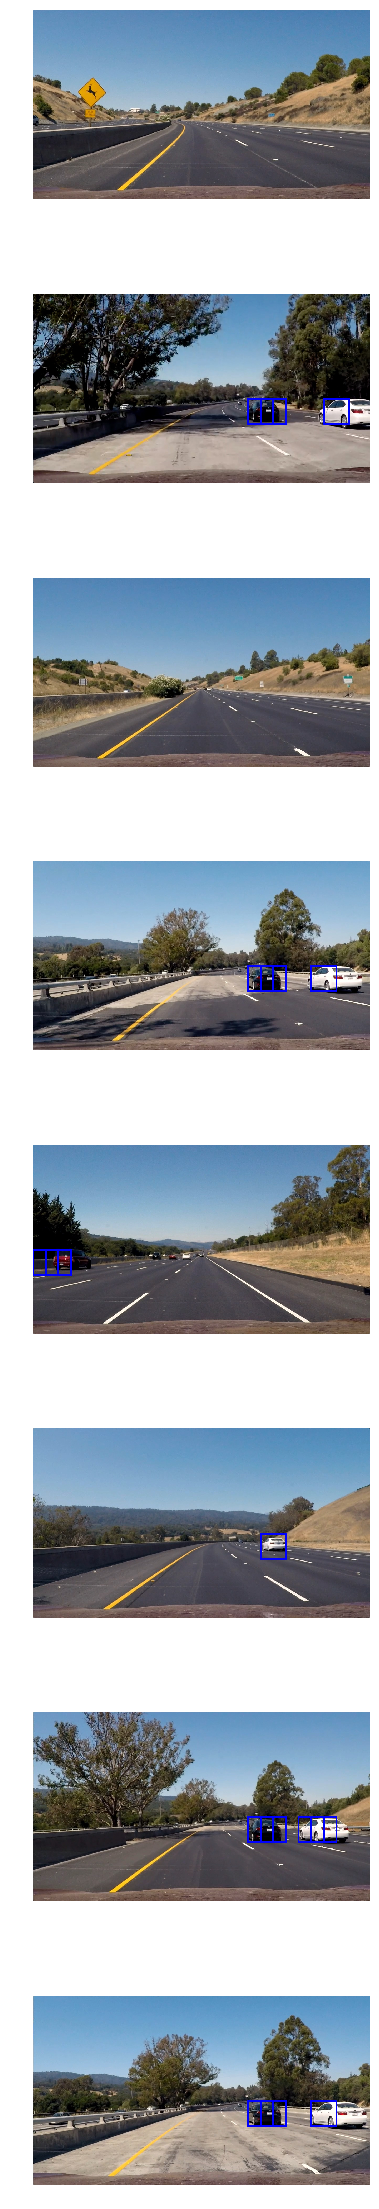

In [261]:
test_images = glob.glob('test_images/*.jpg')


num_of_rows = 8
num_of_cols = 1
image_size = 40

ystart = 400
ystop = 656
scale = 1.5

fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(image_size, image_size))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i = 0
for test_image in test_images:
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)
    hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)      

#     image = X_train[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(window_img)
    write_name = 'test_images_output/find_cars_'+str(i)+'_.jpg'
    write_image = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(write_name, write_image)
    i = i + 1

#### Apply heat map for getting rid of multiple detection of the same object
---
As we can see from the previous images that we do not have false positives but we have multiple detection of the same vehicle.

Here I have used the heat maps to git rid of the multiple detections.

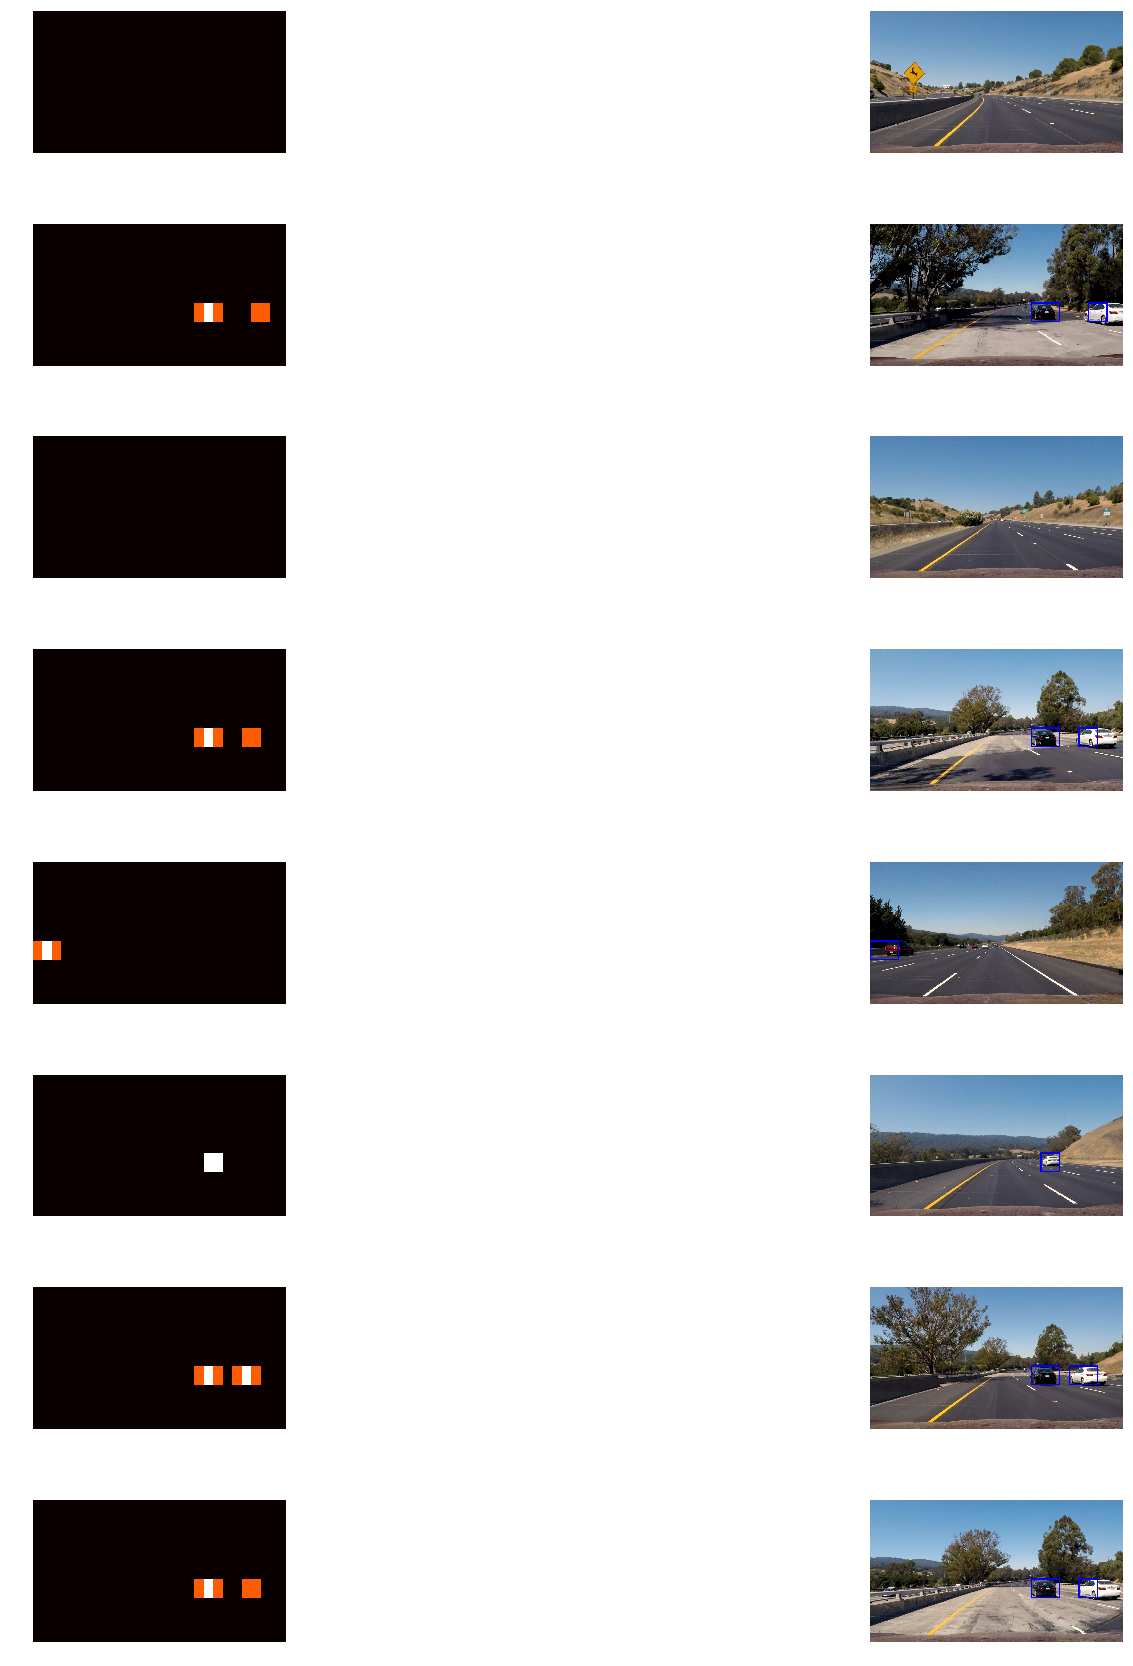

In [270]:
from scipy.ndimage.measurements import label

test_images = glob.glob('test_images/*.jpg')


num_of_rows = 8
num_of_cols = 2
image_size = 30

ystart = 400
ystop = 656
scale = 1.5

fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(image_size, image_size))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i = 0
for test_image in test_images:
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)
    hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)     
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    axs[i].axis('off')
    axs[i].imshow(heatmap, cmap="hot")
    write_name = 'test_images_output/heat_map_'+str(i)+'_.jpg'
    cv2.imwrite(write_name, heatmap)
    i = i + 1
    
    axs[i].axis('off')
    axs[i].imshow(draw_img)
    i = i + 1
    write_name = 'test_images_output/multiple_detection_elim_'+str(i)+'_.jpg'
    write_image = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(write_name, write_image)

### Test on video 

Here I have define a `process_frame` function. In this function I have used the `find_cars` function with heat maps but with different scales to make sure of getting the cars in different sizes through the video frame

In [231]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 600
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    

    scale = 1.75
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    scale = 2
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 0)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


In [248]:
from moviepy.editor import VideoFileClip
white_output = 'test_video_output/small_test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video/test_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output/test_process_frame.mp4
[MoviePy] Writing video test_video_output/test_process_frame.mp4


 97%|█████████▋| 38/39 [00:15<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/test_process_frame.mp4 

CPU times: user 15.7 s, sys: 448 ms, total: 16.2 s
Wall time: 17.4 s


In [249]:
from moviepy.editor import VideoFileClip
white_output = 'test_video_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video/project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output/test_process_frame_fulll.mp4
[MoviePy] Writing video test_video_output/test_process_frame_fulll.mp4


100%|█████████▉| 1260/1261 [08:35<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/test_process_frame_fulll.mp4 

CPU times: user 9min 3s, sys: 3.69 s, total: 9min 6s
Wall time: 8min 37s
